In [1]:
import sys, os
sys.path.remove('C:\\Users\\Nathan\\Documents\\Dropbox\\Python')
sys.path.remove('C:\\users\\nathan\\documents\\Dropbox\\Python\\jpnotebooks\\Customer Apps\\Semma Data Scripts\\ C:\\program files\\python35\\Lib\\site-packages')
sys.path.append('C:\\Users\\Nathan\\Documents\\Dropbox\\Python\\scripts\\customer_apps\\multilogger\\src\\')
os.chdir("..\semma_demo")

## Imports from multilogger module

In [2]:
from multilogger import HelloMultiLogger, MLCallback

## Simple Example: Basic structure of generic callback routine receiving all events:

In [3]:
def callback(event, payload):
    if event == "ML_BEGIN_LOG":
        pass
    elif event == "ML_LOG_DATA":
        pass
    elif event == "ML_END_LOG":
        pass
    else:
        print("Received unknown event: %r"%event)

## Simple Example #2: A callback displaying the event name and payload

In [4]:
def my_callback(event, payload):
    print("Got event:", event)
    if event == "ML_BEGIN_LOG":
        print(*payload)
    elif event == "ML_LOG_DATA":
        print(*payload)
    elif event == "ML_END_LOG":
        pass
    else:
        print("Received unknown event: %r"%event)

## Simple CSV Writer: Using callbacks to open a file, log data received, and close file when done

In [5]:
def csv_writer(filename):
    f = None
    pvars = None
    
    def log(data):
        nonlocal f
        f.write(",".join(map(str, data))); f.write("\n")
    
    def csv_writer_cb(event, payload):
        nonlocal f, pvars
        
        if event == "ML_BEGIN_LOG":
            f = open(filename, 'w')
            
            # create pvars
            pvars = []
            for tag, vl in payload:
                for v in vl:
                    pvars.append(tag + "." + v)
            log(pvars)
        
        elif event == "ML_LOG_DATA":
            line = []
            for tag, vl in payload:
                for v in vl:
                    line.append(v)
            log(line)
        
        elif event == "ML_END_LOG":
            f.close()
        
        else:
            raise ValueError("Unknown event: %r"%event)
    
    return csv_writer_cb

## Simple CSV Writer #2: Class based callback handler.

Instead of using a callback function to process all events, the MLCallback class provides methods to shutter specific events to specific functions

In [6]:
class CSVWriter(MLCallback):
    def __init__(self, filename):
        super().__init__()
        if os.path.exists(filename):
            raise FileExistsError(filename)
        self._filename = filename
        self._f = None
        self._pvars = None
        
    def log_data(self, data):
        if self._f is None:
            raise ValueError("File not initialized")
        self._f.write(",".join(map(str,data)))
        self._f.write("\n")
        
    def onBeginLog(self, payload):
        
        # check file existance again when starting, just in case
        if os.path.exists(self._filename):
            raise FileExistsError(self._filename)
        
        self._f = open(self._filename, 'w')
        
        self._pvars = []
        for tag, vl in payload:
            for v in vl:
                self._pvars.append(tag + "." + v)
                
        self.log_data(self._pvars)
        
    def onDataReceived(self, payload):
        line = []
        for tag, vl in payload:
            for v in vl:
                line.append(v)
                
        self.log_data(line)
        
    def onEndLog(self, payload):
        self._f.close()
        self._f = None

## Example Usage of HelloMultiLogger

In [7]:
import time

# Choose all variables to log. All reactors will log the same variables.
vars_i_care_about = [
    'agitation.pv',
    'temperature.pv'
]

# Create logger 
ml = HelloMultiLogger(vars_i_care_about, 3)

ml.add_logger("192.168.1.12", "R&D1", 1)
ml.add_logger("192.168.1.16", "R&D2", 1)

ml.add_callback(my_callback)
ml.add_callback(csv_writer("test_multilogger.csv"))

# These two are equivalent
ml.add_callback(CSVWriter("test_multilogger2.csv"))
ml.add_callback(CSVWriter("test_multilogger3.csv").onEvent)

ml.start()
time.sleep(12)
ml.stop()

Got event: ML_BEGIN_LOG
('ML', ['Timestamp.Last', 'Elapsed Time.hr']) ('R&D1', ['Timestamp.Last', 'Elapsed Time.hr', 'agitation.pv', 'temperature.pv']) ('R&D2', ['Timestamp.Last', 'Elapsed Time.hr', 'agitation.pv', 'temperature.pv'])
Got event: ML_LOG_DATA
('ML', [datetime.datetime(2018, 10, 11, 10, 23, 54, 364985), 2.8469444444444445e-05]) ('R&D1', [datetime.datetime(2018, 10, 11, 10, 23, 54, 353017), 2.6799444444444442e-05, 0, 20.959339141845703]) ('R&D2', [datetime.datetime(2018, 10, 11, 10, 23, 54, 349112), 2.4890833333333336e-05, 0, 23.1851806640625])
Got event: ML_LOG_DATA
('ML', [datetime.datetime(2018, 10, 11, 10, 23, 57, 365197), 0.0008618616666666666]) ('R&D1', [datetime.datetime(2018, 10, 11, 10, 23, 56, 613737), 0.0006547772222222222, 0, 20.952314376831055]) ('R&D2', [datetime.datetime(2018, 10, 11, 10, 23, 56, 457586), 0.0006105780555555556, 0, 23.187776565551758])
Got event: ML_LOG_DATA
('ML', [datetime.datetime(2018, 10, 11, 10, 24, 0, 366438), 0.0016955397222222222]) ('

In [8]:
os.remove("test_multilogger.csv")
os.remove("test_multilogger2.csv")
os.remove("test_multilogger3.csv")

In [9]:
%matplotlib
import matplotlib
import matplotlib.pyplot as plt

Using matplotlib backend: TkAgg


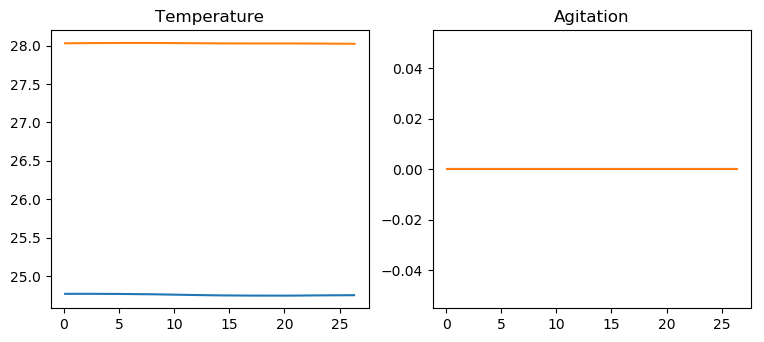

In [13]:
from threading import Lock
ml = HelloMultiLogger(vars_i_care_about, 3)

plt.close()
fig = plt.figure()
tempax = fig.add_subplot(1,2,1, title="Temperature")
agax   = fig.add_subplot(1,2,2, title="Agitation")

class Line():
    def __init__(self, ax):
        self.line = ax.plot([], [])[0]
        self.xd = []
        self.yd = []
        self.lock = Lock()
        self._stale = False
        
        
    def add(self, x, y):
        with self.lock:
            self.xd.append(x)
            self.yd.append(y)
            self._stale = True
        
    def update(self):
        if self._stale:
            with self.lock:
                self.line.set_data(self.xd, self.yd)
                self._stale = False
                return True
        return False

bioreactors = [
    ("192.168.1.12", "R&D1"),
    ("192.168.1.16", "R&D2"),
]

lines = {}
        
for ip, br in bioreactors:
    ml.add_logger(ip, br, 1)    
    brm = lines[br] = {}
    brm["temp"] = Line(tempax)
    brm["ag"] = Line(agax)
    
def mpl_cb():
    tidx = -1
    agidx = -1
    def mpl_cb_inner(ev, payload):
        nonlocal tidx, agidx
        if ev == "ML_BEGIN_LOG":
            vl = payload[1][1]
            for i, v in enumerate(vl):
                if v == "temperature.pv":
                    tidx = i
                elif v == "agitation.pv":
                    agidx = i
            if tidx == -1 or agidx == -1:
                raise ValueError("failed to find proper index")
                
        elif ev == "ML_LOG_DATA":
            for tag, vl in payload:
                if tag in lines:
                    brm = lines[tag]
                    x = vl[1]
                    ytemp = vl[tidx]
                    yag = vl[agidx]

                    brm["temp"].add(x*3600, ytemp)
                    brm["ag"].add(x*3600, yag)                   
                    
    return mpl_cb_inner

ml.add_callback(mpl_cb())

def update_plots():
    update = False
    for m in lines.values():
        for line in m.values():
            if line.update():
                update = True
    if update:
        for ax in (tempax, agax):
            ax.relim(True)
            ax.autoscale_view(True,True,True)
        fig.canvas.draw()
    fig.canvas.flush_events()

ml.start()
end = time.time() + 30
while time.time() < end:
    time.sleep(0.1)
    update_plots()
ml.stop()
plt.close()
fig

In [ ]:
class _BRInfo():
    def __init__(self):
        self._idxl = []
    
    def add_index(self, idx):
        self._idxl.append(idx)

class MPLCallback(MLCallback):
    
    def __init__(self, variables):
        super().__init__()
        self._variables = variables
        self._tags = {}
        
    def onBeginLog(self, payload):
        it = iter(payload); next(it)  # discard ML
        for tag, vl in it:
            info = BRInfo()
            for v in self._variables:
                info.add_index(vl.index(v))
            self._tags[tag] = info
            
    
    def onDataRecieved(self, payload):
        pass
    
    def onEndLog(self, payload):
        pass

In [ ]:


def plot_vars(br_config, variables):
    fig = plt.figure()
    ml = HelloMultiLogger(variables)
    axes = {}
    for ip, br in br_config:
        